In [25]:
import numpy as np
import pandas as pd
import os
from glob import glob
from sklearn.model_selection import train_test_split 

划分训练集和测试集

In [26]:
# 设置数据集根目录路径
root_dir = '/data/nieruichen/Deep-Learning-Intro-Assignments/HWX3/data/lgg-mri-segmentation/kaggle_3m'

# 创建空列表来存储图像-掩码路径对
image_mask_pairs = []

# 遍历根目录下的所有病例文件夹
for case in os.listdir(root_dir):
    # 构建完整的病例目录路径
    case_dir = os.path.join(root_dir, case)
    
    # 跳过非目录文件
    if not os.path.isdir(case_dir):
        continue
    
    # 获取该病例目录下所有的 .tif 文件
    images = glob(os.path.join(case_dir, '*.tif'))
    
    # 遍历每个图像文件
    for img_path in images:
        # 跳过已经是掩码的文件
        if img_path.endswith('_mask.tif'):
            continue
        
        # 根据命名约定生成对应的掩码文件路径
        mask_path = img_path.replace('.tif', '_mask.tif')
        
        # 检查掩码文件是否存在
        if os.path.exists(mask_path):
            # 如果存在，将图像-掩码路径对添加到列表中
            image_mask_pairs.append((img_path, mask_path))

# 划分训练集和测试集（如8:2）
train_pairs, test_pairs = train_test_split(image_mask_pairs, test_size=0.2, random_state=42)

print(f"训练集样本数: {len(train_pairs)}")
print(f"测试集样本数: {len(test_pairs)}")        

训练集样本数: 3143
测试集样本数: 786


图像示例

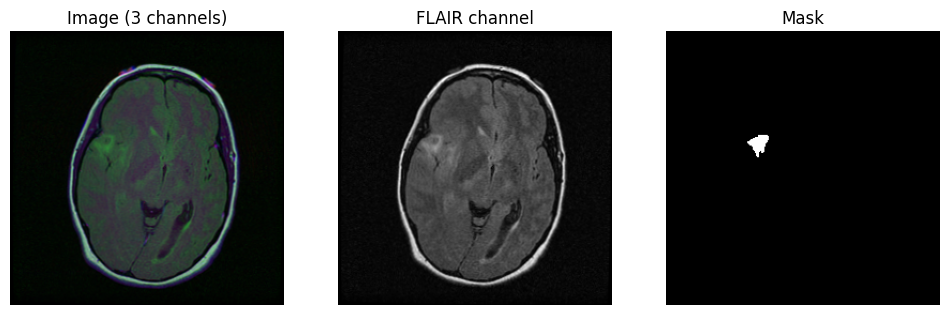

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 

# 取一个训练集样本
img_path, mask_path = train_pairs[0]

# 读取图像和掩码
image = Image.open(img_path)
mask = Image.open(mask_path)

# 可视化
plt.figure(figsize=(12,4))  # 创建12×4英寸的图形窗口

plt.subplot(1,3,1)  # 1行3列的第1个位置
plt.imshow(image)   # 显示三通道彩色图像
plt.title('Image (3 channels)')
plt.axis('off')     # 隐藏坐标轴

plt.subplot(1,3,2)  # 1行3列的第2个位置
# 将PIL图像转为numpy数组，并提取第2个通道（索引为1）
plt.imshow(np.array(image)[:,:,1], cmap='gray')
plt.title('FLAIR channel')
plt.axis('off')

plt.subplot(1,3,3)  # 1行3列的第3个位置
plt.imshow(mask, cmap='gray')  # 灰度显示掩码
plt.title('Mask')
plt.axis('off')

plt.show()

In [28]:
print("Image size:", image.size)
print("Mask size:", mask.size)

Image size: (256, 256)
Mask size: (256, 256)


定义Dataset

In [29]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
class MRISegDataset(Dataset):
    def __init__(self, pairs, transform_img=None, transform_mask=None):
        self.pairs = pairs
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        image = Image.open(img_path)  # 三通道
        mask = Image.open(mask_path)  # 单通道
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        mask = (mask > 0).float()  # 二值化,将掩码中所有大于0的像素值变为1.0，等于0的像素值保持为0.0
        return image, mask

定义transforms和Dataloader

In [30]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [31]:
import torch
from torch.utils.data import DataLoader

img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = MRISegDataset(train_pairs, img_transform, mask_transform)
test_dataset = MRISegDataset(test_pairs, img_transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

定义U-Net模型

In [32]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)#直接改动替换，而不是生成新的占空间
            )#更简洁的写法，相比于普通forward
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        #ConvTranspose2d:反卷积层，用于上采样，将特征图的空间尺寸扩大一倍
        #严格来说是变为原尺寸的stride倍，这里stride=2，所以扩大一倍
        #stride操作：将数据间隔开来插入0值，数量为stride-1，然后padding,卷积,最终扩为stride倍
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        d3 = self.up3(e4)
        d3 = torch.cat([d3, e3], dim=1)#表示在第1维（从0开始计数）上进行拼接
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.final(d1)
        return torch.sigmoid(out)

训练

Dice = 2 × |A ∩ B| / (|A| + |B|)

In [33]:
print(torch.cuda.device_count())

4


使用 4 个GPU进行训练


Epoch [1/50]: 100%|██████████| 99/99 [00:14<00:00,  6.68it/s, acc=0.995, dice=0.761, loss=0.322] 


Epoch 1/50, Loss: 0.4286, Dice: 0.5583, Acc: 0.9761
Current learning rate: 0.001


Epoch [2/50]: 100%|██████████| 99/99 [00:15<00:00,  6.54it/s, acc=0.993, dice=0.528, loss=0.243]


Epoch 2/50, Loss: 0.3074, Dice: 0.6457, Acc: 0.9887
Current learning rate: 0.001


Epoch [3/50]: 100%|██████████| 99/99 [00:14<00:00,  6.80it/s, acc=0.982, dice=0.283, loss=0.308]


Epoch 3/50, Loss: 0.2832, Dice: 0.6576, Acc: 0.9902
Current learning rate: 0.001


Epoch [4/50]: 100%|██████████| 99/99 [00:15<00:00,  6.51it/s, acc=0.994, dice=0.27, loss=0.28]  


Epoch 4/50, Loss: 0.2699, Dice: 0.6085, Acc: 0.9915
Current learning rate: 0.001


Epoch [5/50]: 100%|██████████| 99/99 [00:14<00:00,  6.67it/s, acc=0.991, dice=0.369, loss=0.27] 


Epoch 5/50, Loss: 0.2633, Dice: 0.6247, Acc: 0.9917
Current learning rate: 0.001


Epoch [6/50]: 100%|██████████| 99/99 [00:14<00:00,  6.90it/s, acc=0.987, dice=0.38, loss=0.269] 


Epoch 6/50, Loss: 0.2598, Dice: 0.5992, Acc: 0.9918
Current learning rate: 0.001


Epoch [7/50]: 100%|██████████| 99/99 [00:14<00:00,  6.97it/s, acc=0.993, dice=0.353, loss=0.256]


Epoch 7/50, Loss: 0.2534, Dice: 0.5822, Acc: 0.9925
Current learning rate: 0.001


Epoch [8/50]: 100%|██████████| 99/99 [00:15<00:00,  6.58it/s, acc=0.981, dice=0.697, loss=0.224]


Epoch 8/50, Loss: 0.2507, Dice: 0.6220, Acc: 0.9929
Current learning rate: 0.001


Epoch [9/50]: 100%|██████████| 99/99 [00:15<00:00,  6.52it/s, acc=0.989, dice=0.124, loss=0.286]


Epoch 9/50, Loss: 0.2481, Dice: 0.5880, Acc: 0.9931
Current learning rate: 0.001


Epoch [10/50]: 100%|██████████| 99/99 [00:14<00:00,  7.00it/s, acc=0.995, dice=0.232, loss=0.243]


Epoch 10/50, Loss: 0.2460, Dice: 0.6013, Acc: 0.9933
Current learning rate: 0.001


Epoch [11/50]: 100%|██████████| 99/99 [00:14<00:00,  6.95it/s, acc=0.994, dice=0.4, loss=0.286]  


Epoch 11/50, Loss: 0.2422, Dice: 0.6081, Acc: 0.9938
Current learning rate: 0.001


Epoch [12/50]: 100%|██████████| 99/99 [00:14<00:00,  6.82it/s, acc=0.991, dice=0.594, loss=0.147]


Epoch 12/50, Loss: 0.2395, Dice: 0.6369, Acc: 0.9941
Current learning rate: 0.001


Epoch [13/50]: 100%|██████████| 99/99 [00:13<00:00,  7.23it/s, acc=0.997, dice=0.406, loss=0.272]


Epoch 13/50, Loss: 0.2390, Dice: 0.6193, Acc: 0.9943
Current learning rate: 0.001


Epoch [14/50]: 100%|██████████| 99/99 [00:14<00:00,  6.62it/s, acc=0.992, dice=0.344, loss=0.218]


Epoch 14/50, Loss: 0.2363, Dice: 0.6339, Acc: 0.9946
Current learning rate: 0.001


Epoch [15/50]: 100%|██████████| 99/99 [00:14<00:00,  6.75it/s, acc=0.994, dice=0.663, loss=0.246]


Epoch 15/50, Loss: 0.2344, Dice: 0.6568, Acc: 0.9949
Current learning rate: 0.001


Epoch [16/50]: 100%|██████████| 99/99 [00:15<00:00,  6.59it/s, acc=0.985, dice=0.555, loss=0.311]


Epoch 16/50, Loss: 0.2348, Dice: 0.6626, Acc: 0.9949
Current learning rate: 0.001


Epoch [17/50]: 100%|██████████| 99/99 [00:15<00:00,  6.49it/s, acc=0.993, dice=0.51, loss=0.209] 


Epoch 17/50, Loss: 0.2318, Dice: 0.6684, Acc: 0.9952
Current learning rate: 0.001


Epoch [18/50]: 100%|██████████| 99/99 [00:15<00:00,  6.58it/s, acc=0.997, dice=0.696, loss=0.27] 


Epoch 18/50, Loss: 0.2317, Dice: 0.6730, Acc: 0.9953
Current learning rate: 0.001


Epoch [19/50]: 100%|██████████| 99/99 [00:15<00:00,  6.58it/s, acc=0.999, dice=0.81, loss=0.19]  


Epoch 19/50, Loss: 0.2289, Dice: 0.6849, Acc: 0.9958
Current learning rate: 0.001


Epoch [20/50]: 100%|██████████| 99/99 [00:14<00:00,  6.70it/s, acc=0.996, dice=0.517, loss=0.285]


Epoch 20/50, Loss: 0.2306, Dice: 0.6993, Acc: 0.9954
Current learning rate: 0.001


Epoch [21/50]: 100%|██████████| 99/99 [00:14<00:00,  6.72it/s, acc=0.996, dice=0.924, loss=0.168]


Epoch 21/50, Loss: 0.2291, Dice: 0.7054, Acc: 0.9956
Current learning rate: 0.001


Epoch [22/50]: 100%|██████████| 99/99 [00:14<00:00,  6.76it/s, acc=0.999, dice=0.571, loss=0.301]


Epoch 22/50, Loss: 0.2280, Dice: 0.7033, Acc: 0.9959
Current learning rate: 0.001


Epoch [23/50]: 100%|██████████| 99/99 [00:15<00:00,  6.52it/s, acc=0.997, dice=0.697, loss=0.226]


Epoch 23/50, Loss: 0.2272, Dice: 0.7028, Acc: 0.9960
Current learning rate: 0.0005


Epoch [24/50]: 100%|██████████| 99/99 [00:15<00:00,  6.56it/s, acc=0.997, dice=0.532, loss=0.234]


Epoch 24/50, Loss: 0.2233, Dice: 0.7533, Acc: 0.9966
Current learning rate: 0.0005


Epoch [25/50]: 100%|██████████| 99/99 [00:14<00:00,  6.94it/s, acc=0.996, dice=0.817, loss=0.193]


Epoch 25/50, Loss: 0.2209, Dice: 0.7592, Acc: 0.9969
Current learning rate: 0.0005


Epoch [26/50]: 100%|██████████| 99/99 [00:14<00:00,  6.80it/s, acc=0.997, dice=0.787, loss=0.203]


Epoch 26/50, Loss: 0.2206, Dice: 0.7700, Acc: 0.9970
Current learning rate: 0.0005


Epoch [27/50]: 100%|██████████| 99/99 [00:14<00:00,  6.83it/s, acc=0.995, dice=0.514, loss=0.244]


Epoch 27/50, Loss: 0.2206, Dice: 0.7837, Acc: 0.9969
Current learning rate: 0.0005


Epoch [28/50]: 100%|██████████| 99/99 [00:14<00:00,  6.96it/s, acc=0.997, dice=0.814, loss=0.194]


Epoch 28/50, Loss: 0.2190, Dice: 0.7858, Acc: 0.9972
Current learning rate: 0.0005


Epoch [29/50]: 100%|██████████| 99/99 [00:14<00:00,  6.71it/s, acc=0.998, dice=0.798, loss=0.24] 


Epoch 29/50, Loss: 0.2193, Dice: 0.7912, Acc: 0.9972
Current learning rate: 0.00025


Epoch [30/50]: 100%|██████████| 99/99 [00:15<00:00,  6.58it/s, acc=0.997, dice=0.953, loss=0.109]


Epoch 30/50, Loss: 0.2157, Dice: 0.8088, Acc: 0.9975
Current learning rate: 0.00025


Epoch [31/50]: 100%|██████████| 99/99 [00:15<00:00,  6.58it/s, acc=0.996, dice=0.756, loss=0.129]


Epoch 31/50, Loss: 0.2151, Dice: 0.8116, Acc: 0.9976
Current learning rate: 0.00025


Epoch [32/50]: 100%|██████████| 99/99 [00:13<00:00,  7.12it/s, acc=0.998, dice=0.499, loss=0.242]


Epoch 32/50, Loss: 0.2165, Dice: 0.7947, Acc: 0.9975
Current learning rate: 0.00025


Epoch [33/50]: 100%|██████████| 99/99 [00:14<00:00,  6.67it/s, acc=0.999, dice=0.961, loss=0.23] 


Epoch 33/50, Loss: 0.2156, Dice: 0.8165, Acc: 0.9977
Current learning rate: 0.00025


Epoch [34/50]: 100%|██████████| 99/99 [00:14<00:00,  6.86it/s, acc=0.995, dice=0.808, loss=0.242]


Epoch 34/50, Loss: 0.2152, Dice: 0.8058, Acc: 0.9977
Current learning rate: 0.000125


Epoch [35/50]: 100%|██████████| 99/99 [00:14<00:00,  6.93it/s, acc=0.994, dice=0.73, loss=0.186] 


Epoch 35/50, Loss: 0.2135, Dice: 0.8311, Acc: 0.9979
Current learning rate: 0.000125


Epoch [36/50]: 100%|██████████| 99/99 [00:14<00:00,  6.95it/s, acc=0.999, dice=0.857, loss=0.301]


Epoch 36/50, Loss: 0.2140, Dice: 0.8399, Acc: 0.9979
Current learning rate: 0.000125


Epoch [37/50]: 100%|██████████| 99/99 [00:14<00:00,  6.95it/s, acc=1, dice=0.99, loss=0.261]     


Epoch 37/50, Loss: 0.2130, Dice: 0.8463, Acc: 0.9980
Current learning rate: 0.000125


Epoch [38/50]: 100%|██████████| 99/99 [00:14<00:00,  6.64it/s, acc=0.999, dice=0.571, loss=0.303]


Epoch 38/50, Loss: 0.2132, Dice: 0.8352, Acc: 0.9980
Current learning rate: 0.000125


Epoch [39/50]: 100%|██████████| 99/99 [00:15<00:00,  6.56it/s, acc=0.997, dice=0.723, loss=0.178]


Epoch 39/50, Loss: 0.2119, Dice: 0.8398, Acc: 0.9980
Current learning rate: 6.25e-05


Epoch [40/50]: 100%|██████████| 99/99 [00:14<00:00,  6.70it/s, acc=0.998, dice=0.824, loss=0.186]


Epoch 40/50, Loss: 0.2113, Dice: 0.8373, Acc: 0.9981
Current learning rate: 6.25e-05


Epoch [41/50]: 100%|██████████| 99/99 [00:14<00:00,  6.69it/s, acc=0.999, dice=0.541, loss=0.227]


Epoch 41/50, Loss: 0.2112, Dice: 0.8453, Acc: 0.9982
Current learning rate: 6.25e-05


Epoch [42/50]: 100%|██████████| 99/99 [00:15<00:00,  6.53it/s, acc=0.997, dice=0.934, loss=0.117]


Epoch 42/50, Loss: 0.2104, Dice: 0.8369, Acc: 0.9981
Current learning rate: 6.25e-05


Epoch [43/50]: 100%|██████████| 99/99 [00:14<00:00,  6.77it/s, acc=0.998, dice=0.429, loss=0.304]


Epoch 43/50, Loss: 0.2116, Dice: 0.8385, Acc: 0.9982
Current learning rate: 6.25e-05


Epoch [44/50]: 100%|██████████| 99/99 [00:14<00:00,  6.91it/s, acc=0.999, dice=0.571, loss=0.302]


Epoch 44/50, Loss: 0.2114, Dice: 0.8470, Acc: 0.9982
Current learning rate: 3.125e-05


Epoch [45/50]: 100%|██████████| 99/99 [00:15<00:00,  6.57it/s, acc=0.994, dice=0.842, loss=0.161]


Epoch 45/50, Loss: 0.2098, Dice: 0.8623, Acc: 0.9982
Current learning rate: 3.125e-05


Epoch [46/50]: 100%|██████████| 99/99 [00:14<00:00,  6.88it/s, acc=0.996, dice=0.462, loss=0.216]


Epoch 46/50, Loss: 0.2103, Dice: 0.8385, Acc: 0.9982
Current learning rate: 3.125e-05


Epoch [47/50]: 100%|██████████| 99/99 [00:14<00:00,  6.84it/s, acc=0.996, dice=0.708, loss=0.228]


Epoch 47/50, Loss: 0.2103, Dice: 0.8470, Acc: 0.9983
Current learning rate: 3.125e-05


Epoch [48/50]: 100%|██████████| 99/99 [00:14<00:00,  6.65it/s, acc=0.997, dice=0.557, loss=0.23] 


Epoch 48/50, Loss: 0.2101, Dice: 0.8399, Acc: 0.9983
Current learning rate: 1.5625e-05


Epoch [49/50]: 100%|██████████| 99/99 [00:15<00:00,  6.60it/s, acc=0.998, dice=0.703, loss=0.222]


Epoch 49/50, Loss: 0.2098, Dice: 0.8469, Acc: 0.9983
Current learning rate: 1.5625e-05


Epoch [50/50]: 100%|██████████| 99/99 [00:15<00:00,  6.56it/s, acc=0.998, dice=0.826, loss=0.23] 


Epoch 50/50, Loss: 0.2097, Dice: 0.8488, Acc: 0.9983
Current learning rate: 1.5625e-05


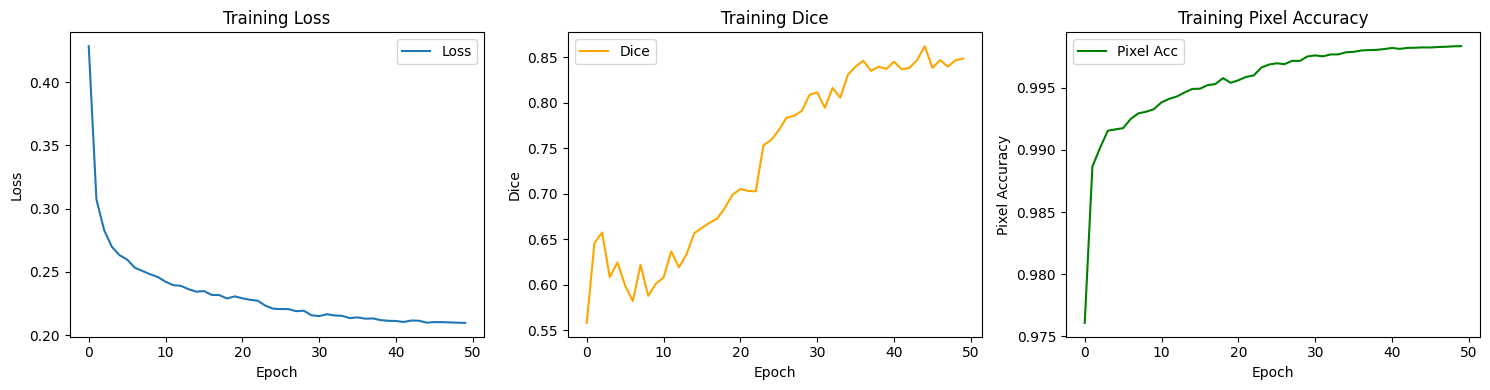

In [34]:
from tqdm import tqdm

def dice_coef(pred, target, threshold=0.5, eps=1e-6):
    pred = (pred > threshold).float()#二值化
    intersection = (pred * target).sum(dim=(1,2,3))#对1,2,3维度求和，相当与只剩下batch维度
    return ((2. * intersection+eps) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps)).mean().item()

def dice_loss(pred, target, threshold=0.5, eps=1e-6):
    # 不做二值化，直接用概率
    intersection = (pred * target).sum(dim=(1,2,3))
    return 1 - ((2. * intersection+eps) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps)).mean()

def pixel_accuracy(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return (correct / total).item()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()

if torch.cuda.device_count() > 1:
    print("使用", torch.cuda.device_count(), "个GPU进行训练")
    model = torch.nn.DataParallel(model)

model = model.to(device)
bce_criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5,threshold=0.01,
    min_lr=1e-5) 

train_loss_list = []
train_dice_list = []
train_acc_list = []

epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    epoch_acc = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")
    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        bce = bce_criterion(outputs, masks)
        d_loss = dice_loss(outputs, masks)
        loss = 0.7 * bce + 0.3 * d_loss  # 加权损失
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        dice = dice_coef(outputs, masks)
        acc = pixel_accuracy(outputs, masks)
        epoch_dice += dice
        epoch_acc += acc
        loop.set_postfix(loss=loss.item(), dice=dice, acc=acc)
    avg_loss = epoch_loss / len(train_loader)
    avg_dice = epoch_dice / len(train_loader)
    avg_acc = epoch_acc / len(train_loader)
    train_loss_list.append(avg_loss)
    train_dice_list.append(avg_dice)
    train_acc_list.append(avg_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Dice: {epoch_dice/len(train_loader):.4f}, Acc: {epoch_acc/len(train_loader):.4f}")
    scheduler.step(avg_loss)
    print("Current learning rate:", scheduler.get_last_lr()[0])  # 打印当前学习率
    if scheduler.get_last_lr()[0] <= 1e-5:
        print("Learning rate has reached the minimum threshold. Stopping training.")
        break 
# 画出训练过程中的loss、dice、acc曲线
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(train_loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_dice_list, label='Dice', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Training Dice')
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_acc_list, label='Pixel Acc', color='green')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Training Pixel Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

测试

In [37]:
# 测试集评估与可视化
model.eval()
test_loss = 0
test_dice = 0
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = 0.7 * bce_criterion(outputs, masks) + 0.3 * dice_loss(outputs, masks)
        test_loss += loss.item()
        dice = dice_coef(outputs, masks)
        test_dice += dice

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Dice: {test_dice/len(test_loader):.4f}")  

Testing: 100%|██████████| 25/25 [00:02<00:00,  8.58it/s]

Test Loss: 0.2230, Test Dice: 0.8020


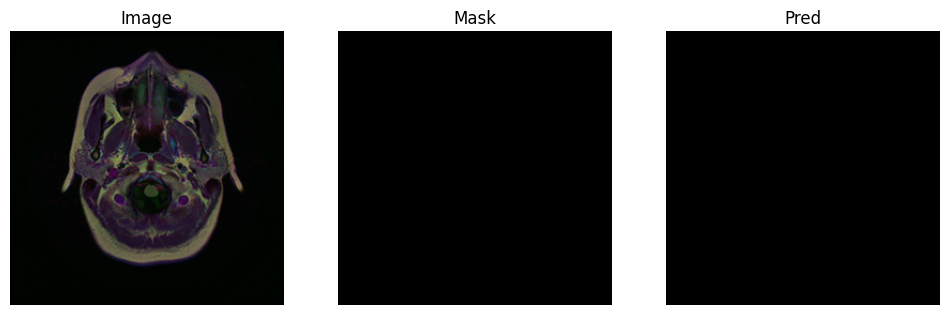

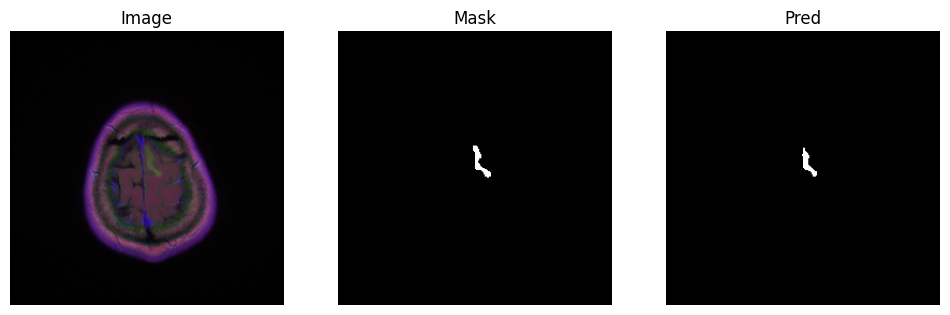

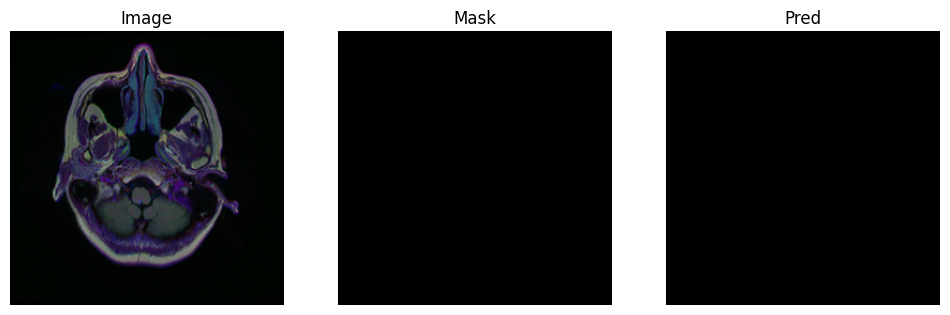

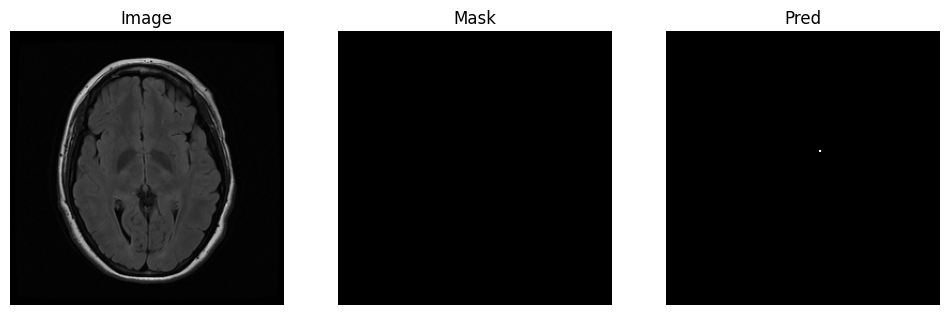

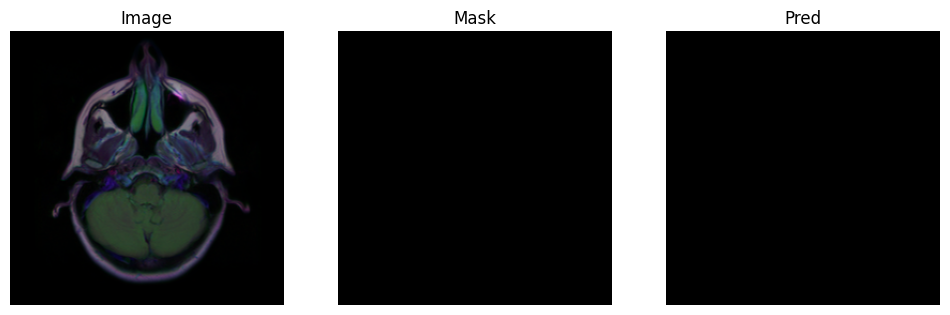

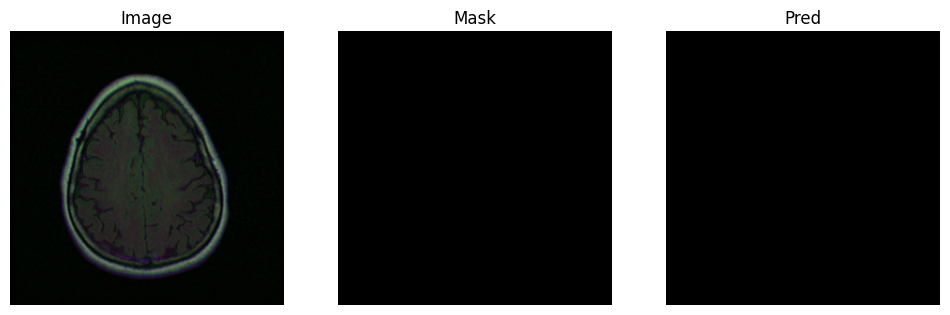

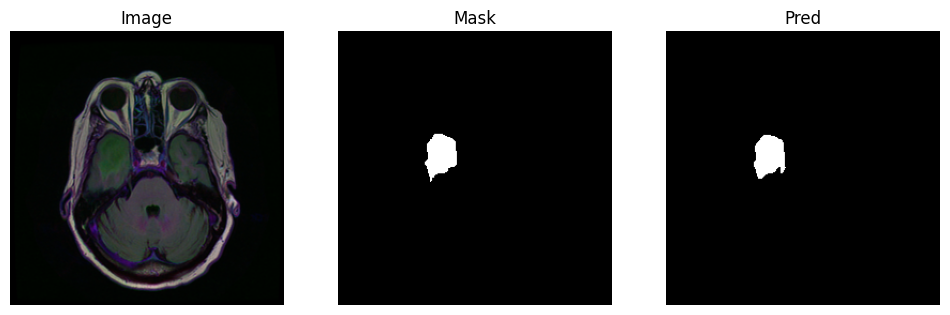

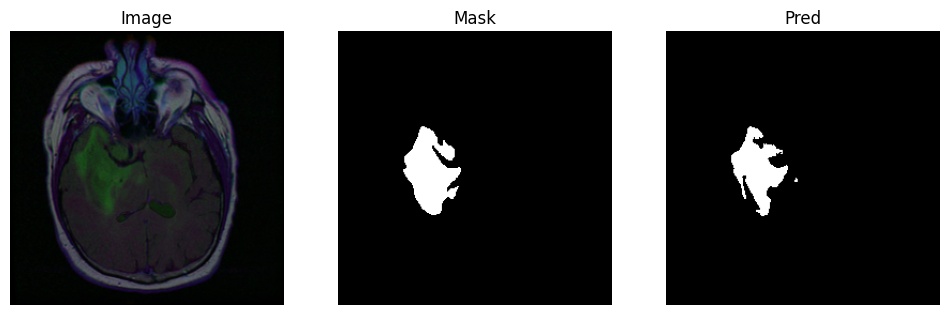

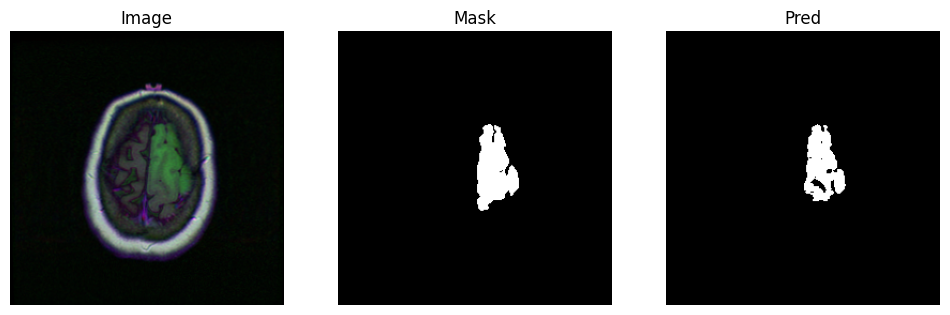

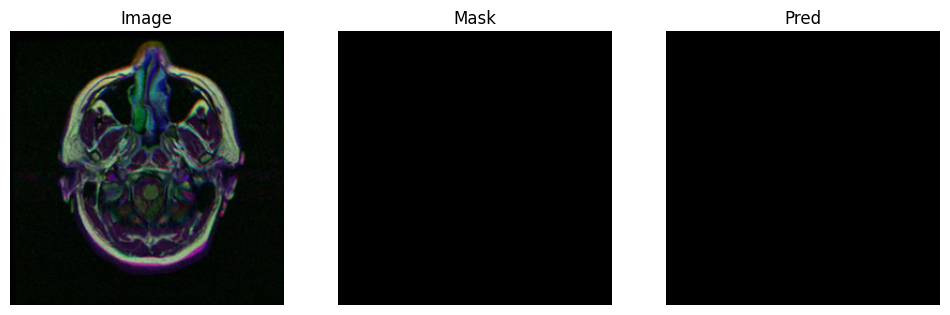

In [36]:
# 可视化部分样本
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    n=0
    for images, masks in test_loader:
        n+=1
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(images[0].cpu().permute(1,2,0))
        """
        重新排列张量的维度。PyTorch通常使用(channels, height, width)的顺序（CHW格式），
        而matplotlib的imshow函数期望的是(height, width, channels)的顺序（HWC格式）。
        这个操作将维度从(C, H, W)转换为(H, W, C)。
        """
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(masks[0][0].cpu(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(preds[0][0].cpu(), cmap='gray')
        plt.title('Pred')
        plt.axis('off')
        plt.show()
        if n>=10:
            break  # 只显示10个样本